Name | Matr.Nr. | Due Date
:--- | ---: | ---:
Darina Petrova | 12230205 | 17.06.2024, 09:30

<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 6 – Language Modeling with LSTM (Assignment)</h2>

<b>Authors:</b> N. Rekabsaz, B. Schäfl, S. Lehner, J. Brandstetter, E. Kobler, M. Abbass, A. Schörgenhumer<br>
<b>Date:</b> 10-06-2024

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>
<p><p>This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which might require small code modifications. Most/All of the used functions are imported from the file <code>u6_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u6_utils.py</code> need to be installed.</p></p>

In [1]:
import u6_utils as u6

import numpy as np
import torch
import os
import time
import math
import ipdb
import matplotlib.pyplot as plt
import seaborn as sns

# Set default plotting style.
sns.set_theme()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u6.setup_jupyter()

# Check minimum versions.
u6.check_module_versions()

Installed Python version: 3.10 (✓)
Installed numpy version: 1.25.2 (✓)
Installed pandas version: 2.0.3 (✓)
Installed PyTorch version: 2.1.1+cu118 (✓)


<h2>Language Model Training and Evaluation</h2>

<h3 style="color:rgb(0,120,170)">Data & Dictionary Preperation</h3>

<div class="alert alert-warning">
    <b>Exercise 1. [20 Points]</b>
        <ul>
            <li>Setup the data set using the same parameter settings as in the main exercise notebook but with the changes mentioned below.</li>
            <li>Change the batch size in the initial parameters to $64$ and observe its effect on the created batches. Explain how the corpora are transformed into batches.</li>
            <li>Use a seed of $23$.</li>
            <li>For a specific sequence in <code>val_data_splits</code> (e.g., index $15$), print the corresponding words of its first 25 wordIDs.</li>
        </ul>
</div>

In [2]:
# your code goes here
data_path = os.path.join("resources", "penn")
save_path = "model.pt" # path to save the final model

# Training & evaluation parameters
train_batch_size = 64 # batch size for training
eval_batch_size = 64 # batch size for validation/test
max_seq_len = 40 # sequence length

# Random seed to facilitate reproducibility
torch.manual_seed(23)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# print("Device:", device)
###################
train_corpus = u6.Corpus(os.path.join(data_path, "train.txt"))
valid_corpus = u6.Corpus(os.path.join(data_path, "valid.txt"))
test_corpus = u6.Corpus(os.path.join(data_path, "test.txt"))

dictionary = u6.Dictionary()
train_corpus.fill_dictionary(dictionary)
ntokens = len(dictionary)
# print(f"Number of tokens in dictionary {ntokens}")
###################
train_data = train_corpus.words_to_ids(dictionary)
# print(f"Train data: number of tokens {len(train_data)}")

valid_data = valid_corpus.words_to_ids(dictionary)
# print(f"Validation data: number of tokens {len(valid_data)}")

test_data = test_corpus.words_to_ids(dictionary)
# print(f"Test data: number of tokens {len(test_data)}")

train_data_splits = u6.batchify(train_data, train_batch_size, device)
# print(f"Train data split shape: {train_data_splits.shape}")

val_data_splits = u6.batchify(valid_data, eval_batch_size, device)
# print(f"Validation data split shape: {val_data_splits.shape}")

test_data_splits = u6.batchify(test_data, eval_batch_size, device)
# print(f"Test data batchified shape: {test_data_splits.shape}")

###################
for i in range(25):
    print(dictionary.idx2word[val_data_splits[15][i]])

<unk>
video
of
in
and
as
accounts
crude
marine
it
vested
on
<eos>
're
said
of
is
the
looked
sales
<unk>
a
as
<eos>
<eos>


The 1D corpus data is reshaped into a two-dimensional tensor given a batch size.
The input shape (N) is transformed into (N//B, B), where N is the number of elements in the given data and B is the batch size. If the input shape is not divisible without remainder, the remaining elements are dropped.

<div class="alert alert-warning">
    <b>Exercise 2. [20 Points]</b>
        <ul>
            <li>Copy the implementation of <code>LM_LSTMModel</code> from the main exercise notebook but make the following changes:</li>
            <ul>
                <li>Add an integer parameter to <code>LM_LSTMModel</code>'s initialization, called <code>num_layers</code> which indicates the number of (vertically) stacked LSTM blocks. Hint: PyTorch's LSTM implementation directly supports this, so you simply have to set it when creating the LSTM instance (see parameter <code>num_layers</code> in the <a href="https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html">documentation</a>).</li>
                <li>Add a new bool parameter to <code>LM_LSTMModel</code>'s initialization, called <code>tie_weights</code>. Extend the implementation of <code>LM_LSTMModel</code> such that if <code>tie_weights</code> is set to <code>True</code>, the model ties/shares the parameters of <code>encoder</code> with the ones of <code>decoder</code>. Consider that <code>encoder</code> and <code>decoder</code> still remain separate components but their parameters are now the same (shared). This process is called <i>weight tying</i>. Feel free to search the internet for relevant resources and implementation hints.</li>
            </ul>
            <li>Create four models:</li>
            <ul>
                <li>1 layer and without weight tying</li>
                <li>1 layer and with weight tying</li>
                <li>2 layers and without weight tying</li>
                <li>2 layers and with weight tying</li>
            </ul>
            <li>Compare the number of parameters of the models and report your observations.</li>
        </ul>
</div>

In [3]:
# your code goes here
class LM_LSTMModel(torch.nn.Module):
    
    def __init__(self, ntoken, ninp, nhid, num_layers, tie_weights):
        super().__init__()
        self.ntoken = ntoken
        self.encoder = torch.nn.Embedding(ntoken, ninp) # matrix E in the figure
        self.rnn = torch.nn.LSTM(ninp, nhid, num_layers)
        self.decoder = torch.nn.Linear(nhid, ntoken) # matrix U in the figure
        self.num_layers = num_layers
        self.tie_weights = tie_weights
        # https://discuss.pytorch.org/t/how-to-create-and-train-a-tied-autoencoder/2585/4
        # used jekbradbury 's answer from here, since it's simple and I get less parameters and there's no need to transpose, the shapes of both are [10001, 200]
        if tie_weights:
            self.decoder.weight = self.encoder.weight
            
    
    def forward(self, input, hidden=None, return_logs=True):
        # ipdb.set_trace()
        emb = self.encoder(input)
        hiddens, last_hidden = self.rnn(emb, hidden)
        
        decoded = self.decoder(hiddens)
        if return_logs:
            y_hat = torch.nn.LogSoftmax(dim=-1)(decoded)
        else:
            y_hat = torch.nn.Softmax(dim=-1)(decoded)
        
        return y_hat, last_hidden

#########################
emsize = 200  # size of word embeddings
nhid = 200  # number of hidden units per layer

###
torch.manual_seed(23)
model1_no_tying = LM_LSTMModel(ntokens, emsize, nhid, num_layers=1, tie_weights=False)
model1_no_tying.to(device)

print(f"Model: {model1_no_tying}")
print(f"Model with 1 layer and without weight tying total trainable parameters: {sum(p.numel() for p in model1_no_tying.parameters() if p.requires_grad)}\n\n\n")
###
torch.manual_seed(23)
model1_tying = LM_LSTMModel(ntokens, emsize, nhid, num_layers=1, tie_weights=True)
model1_tying.to(device)

print(f"Model: {model1_tying}")
print(f"Model with 1 layer and with weight tying total trainable parameters: {sum(p.numel() for p in model1_tying.parameters() if p.requires_grad)}\n\n\n")
###
torch.manual_seed(23)
model2_no_tying = LM_LSTMModel(ntokens, emsize, nhid, num_layers=2, tie_weights=False)
model2_no_tying.to(device)

print(f"Model: {model2_no_tying}")
print(f"Model with 2 layers and without weight tying total trainable parameters: {sum(p.numel() for p in model2_no_tying.parameters() if p.requires_grad)}\n\n\n")
###
torch.manual_seed(23)
model2_tying = LM_LSTMModel(ntokens, emsize, nhid, num_layers=2, tie_weights=True)
model2_tying.to(device)

print(f"Model: {model2_tying}")
print(f"Model with 2 layers and with weight tying total trainable parameters: {sum(p.numel() for p in model2_tying.parameters() if p.requires_grad)}")


Model: LM_LSTMModel(
  (encoder): Embedding(10001, 200)
  (rnn): LSTM(200, 200)
  (decoder): Linear(in_features=200, out_features=10001, bias=True)
)
Model with 1 layer and without weight tying total trainable parameters: 4332001



Model: LM_LSTMModel(
  (encoder): Embedding(10001, 200)
  (rnn): LSTM(200, 200)
  (decoder): Linear(in_features=200, out_features=10001, bias=True)
)
Model with 1 layer and with weight tying total trainable parameters: 2331801



Model: LM_LSTMModel(
  (encoder): Embedding(10001, 200)
  (rnn): LSTM(200, 200, num_layers=2)
  (decoder): Linear(in_features=200, out_features=10001, bias=True)
)
Model with 2 layers and without weight tying total trainable parameters: 4653601



Model: LM_LSTMModel(
  (encoder): Embedding(10001, 200)
  (rnn): LSTM(200, 200, num_layers=2)
  (decoder): Linear(in_features=200, out_features=10001, bias=True)
)
Model with 2 layers and with weight tying total trainable parameters: 2653401


The models with 2 layers have a bit more parameters than their respective weight tying variations (4_332_001 vs 4_653_601 and 2_331_801 vs 2_653_401), which is to be expected, since 1 more layer accounts for more layer parameters to train.
<br><br>
The models with shared weights have a bit over half of the parameters for their non-shared weights counterparts (4_332_001 vs 2_331_801 and 4_653_601 vs 2_653_401), also expected, since the weights are the trainable parameters and they're shared.

<h3 style="color:rgb(0,120,170)">Training and Evaluation</h3>


<div class="alert alert-warning">
    <b>Exercise 3. [30 Points]</b>
    <ul>
        <li>Using the same setup as in the main lecture/exercise notebook, train all four models for $5$ epochs.</li>
        <li>Using <code>ipdb</code>, look inside the <code>forward</code> function of <code>LM_LSTMModel</code> during training. Check the forward process from input to output particularly by looking at the shapes of tensors. Report the shape of all tensors used in <code>forward</code>. Try to translate the numbers into batches $B$ and sequence length $L$. For instance, if we know that the batch size is $B=32$, a tensor of shape $(32, 128, 3)$ can be interpreted as a batch of $32$ sequences with $3$ channels of size $L=128$. Thus, this tensor can be translated into $(32, 128, 3) \rightarrow (B, L, 3)$. Look at the <a href="https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html">official documentation</a> to understand the order of the dimensions.</li>
        <li>Evaluate the models. Compare the performances of all four models on the train, validation and test set (for the test set, use the best model according to the respective validation set performance), and report your observations. To do so, create a plot showing the following curves:</li>
        <ul>
            <li>Loss on each current training batch before every model update step as function of epochs</li>
            <li>Loss on the validation set at every epoch</li>
        </ul>
        <li>Comment on the results!</li>
    </ul>
</div>

In [4]:
# your code goes here
CUT_AFTER_BATCHES = -1  # JUST FOR DEBUGGING: cut the loop after these number of batches. Set to -1 to ignore


def train(model: torch.nn.Module, optimizer: torch.optim.Optimizer, dictionary: u6.Dictionary,
          max_seq_len: int, train_batch_size: int, train_data_splits,
          clipping: float, learning_rate: float, print_interval: int, epoch: int,
          criterion: torch.nn.Module = torch.nn.NLLLoss(), str_=None): ###### MY CHANGE
    """
    Train the model. Training mode turned on to enable dropout.
    """
    model.train()
    total_loss = 0.0
    start_time = time.time()
    ntokens = len(dictionary)
    start_hidden = None
    n_batches = (train_data_splits.size(0) - 1) // max_seq_len
    
    for batch_i, i in enumerate(range(0, train_data_splits.size(0) - 1, max_seq_len)):
        batch_data, batch_targets = u6.get_batch(train_data_splits, i, max_seq_len)
        # ipdb.set_trace()
        
        # Don't forget it! Otherwise, the gradients are summed together!
        optimizer.zero_grad()
        
        # Repackaging batches only keeps the value of start_hidden and disconnects its computational graph.
        # If repackaging is not done the, gradients are calculated from the current point to the beginning
        # of the sequence which becomes computationally too expensive.
        if start_hidden is not None:
            start_hidden = u6.repackage_hidden(start_hidden)
        
        # Forward pass
        y_hat_logprobs, last_hidden = model(batch_data, start_hidden, return_logs=True)
        
        # Loss computation & backward pass
        y_hat_logprobs = y_hat_logprobs.view(-1, ntokens)
        loss = criterion(y_hat_logprobs, batch_targets.view(-1))

        train_losses.append((str_, float(loss), epoch, batch_i)) ###### MY CHANGE
        
        loss.backward()
        
        # The last hidden states of the current step is set as the start hidden state of the next step.
        # This passes the information of the current batch to the next batch.
        start_hidden = last_hidden
        
        # Clipping gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clipping)
        
        # Updating parameters using SGD
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_i % print_interval == 0 and batch_i > 0:
            cur_loss = total_loss / print_interval
            elapsed = time.time() - start_time
            throughput = elapsed * 1000 / print_interval
            print(f"| epoch {epoch:3d} | {batch_i:5d}/{n_batches:5d} batches | lr {learning_rate:02.2f} | ms/batch {throughput:5.2f} "
                  f"| loss {cur_loss:5.2f} | perplexity {math.exp(cur_loss):8.2f}")
            total_loss = 0
            start_time = time.time()
        
        # Cuts the loop (only for debugging)
        if (CUT_AFTER_BATCHES != -1) and (batch_i >= CUT_AFTER_BATCHES):
            print(f"WARNING: Training is interrupted after {batch_i} batches")
            break           

models = [(model1_no_tying, 'Model with 1 layer and without weight tying'),  ###### MY CHANGE
          (model1_tying, 'Model with 1 layer and with weight tying'),        ###### MY CHANGE            
          (model2_no_tying, 'Model with 2 layers and without weight tying'), ###### MY CHANGE           
          (model2_tying, 'Model with 2 layers and with weight tying')]       ###### MY CHANGE

train_losses=[]           ###### MY CHANGE
val_losses = []           ###### MY CHANGE

best_val_loss = None      ###### MY CHANGE
for model,str_ in models: ###### MY CHANGE
    print("-" * 150)      ###### MY CHANGE
    print(str_, ':')      ###### MY CHANGE
    
    epochs = 5  # total number of training epochs                                    
    print_interval = 25  # print report statistics every x batches
    lr = 20  # initial learning rate
    clipping = 0.25  # gradient clipping
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Loop over epochs.
    for epoch in range(epochs):
        epoch_start_time = time.time()
        train(model, optimizer, dictionary, max_seq_len, train_batch_size, train_data_splits, clipping, lr, print_interval, epoch, str_= str_) ###### MY CHANGE
        val_loss = u6.evaluate(model, dictionary, max_seq_len, eval_batch_size, val_data_splits)

        val_losses.append((str_, val_loss, epoch)) ###### MY CHANGE
        
        print("-" * 100)
        print(f"| end of epoch {epoch:3d} | time: {time.time() - epoch_start_time:5.2f}s"
              f"| valid loss {val_loss:5.2f} | valid perplexity {math.exp(val_loss):8.2f}")
        print("-" * 100)
        
        # Save the model if the validation loss is the best we've seen so far.
        if not best_val_loss or val_loss < best_val_loss:
            with open(save_path, "wb") as f:
                torch.save(model, f)
            best_val_loss = val_loss
        else:
            # Anneal the learning rate if no improvement has been seen in the validation dataset.
            lr /= 4.0
            for g in optimizer.param_groups:
                g["lr"] = lr

------------------------------------------------------------------------------------------------------------------------------------------------------
Model with 1 layer and without weight tying :
| epoch   0 |    25/  363 batches | lr 20.00 | ms/batch 284.91 | loss  7.29 | perplexity  1465.90
| epoch   0 |    50/  363 batches | lr 20.00 | ms/batch 280.76 | loss  6.04 | perplexity   418.74
| epoch   0 |    75/  363 batches | lr 20.00 | ms/batch 280.49 | loss  5.85 | perplexity   347.06
| epoch   0 |   100/  363 batches | lr 20.00 | ms/batch 281.43 | loss  5.75 | perplexity   314.79
| epoch   0 |   125/  363 batches | lr 20.00 | ms/batch 283.71 | loss  5.65 | perplexity   283.25
| epoch   0 |   150/  363 batches | lr 20.00 | ms/batch 283.76 | loss  5.51 | perplexity   246.68
| epoch   0 |   175/  363 batches | lr 20.00 | ms/batch 283.38 | loss  5.58 | perplexity   265.89
| epoch   0 |   200/  363 batches | lr 20.00 | ms/batch 281.76 | loss  5.62 | perplexity   276.16
| epoch   0 |   225

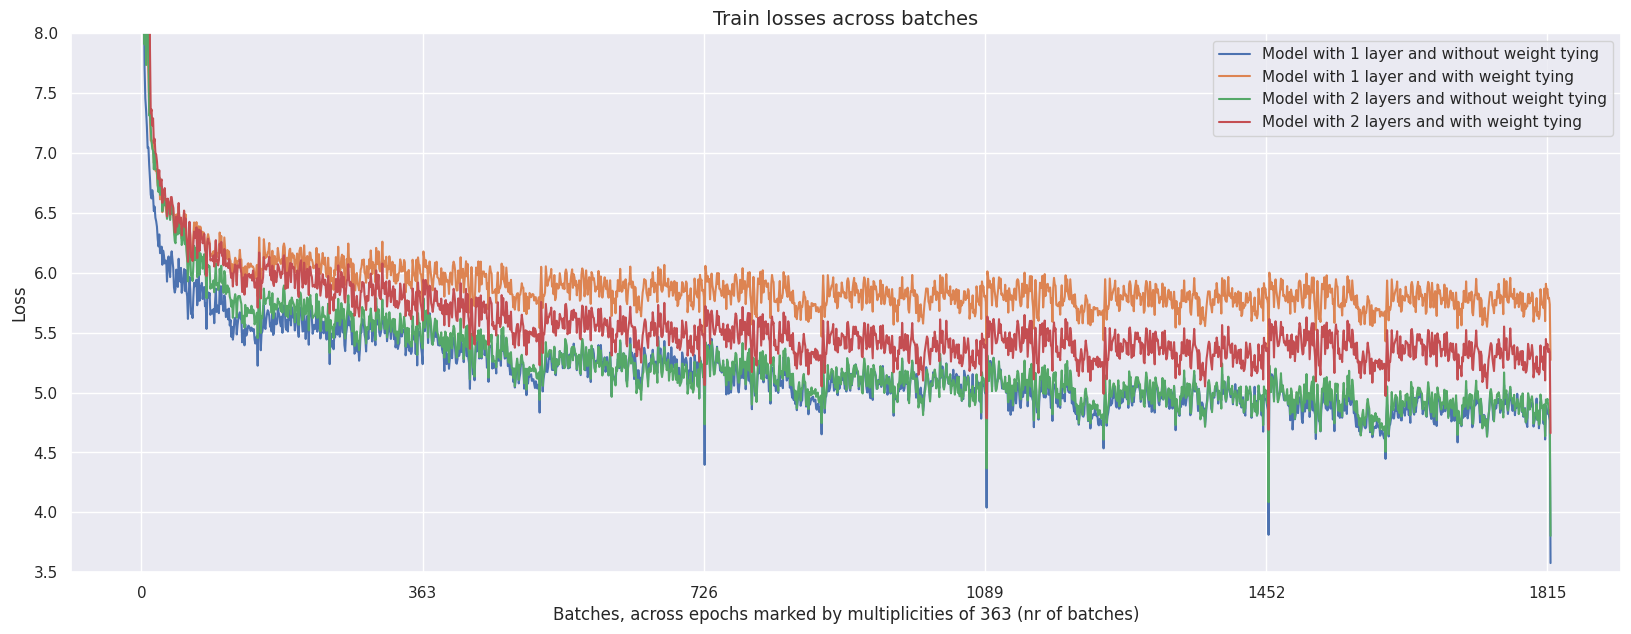

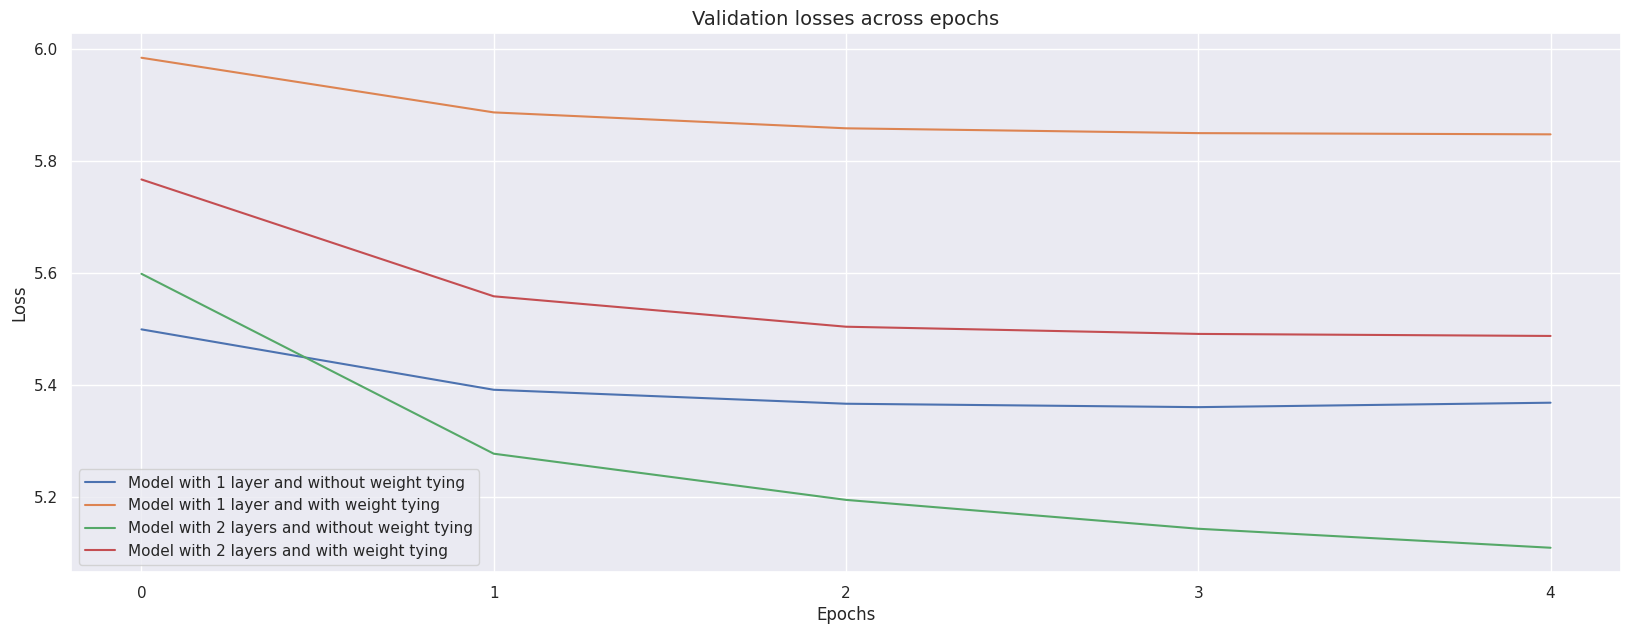

Best model is:  Model with 2 layers and without weight tying
| Test loss  5.07 | test perplexity 159.84


In [5]:
fig, ax = plt.subplots(figsize=(20, 7))

ax.set_title('Train losses across batches', fontsize=14)

losses1_no_wt = [(x[1]) for x in train_losses if x[0] == 'Model with 1 layer and without weight tying']
x = [i for i in range(len(losses1_no_wt))]
plt.plot(x, losses1_no_wt, label='Model with 1 layer and without weight tying')

losses1_wt = [(x[1]) for x in train_losses if x[0] == 'Model with 1 layer and with weight tying']
plt.plot(x, losses1_wt, label='Model with 1 layer and with weight tying')


losses2_no_wt = [(x[1]) for x in train_losses if x[0] == 'Model with 2 layers and without weight tying']
plt.plot(x, losses2_no_wt, label='Model with 2 layers and without weight tying')

losses2_wt = [(x[1]) for x in train_losses if x[0] == 'Model with 2 layers and with weight tying']
plt.plot(x, losses2_wt, label='Model with 2 layers and with weight tying')

xticks = range(0, len(losses1_no_wt), 363)

ax.set(xlabel='Batches, across epochs marked by multiplicities of 363 (nr of batches)', ylabel='Loss', xticks=xticks, ylim=[3.5,8])

plt.legend()
plt.show()

######################

fig, ax = plt.subplots(figsize=(20, 7))

ax.set_title('Validation losses across epochs', fontsize=14)

vlosses1_no_wt = [(x[1]) for x in val_losses if x[0] == 'Model with 1 layer and without weight tying']
x = [i for i in range(len(vlosses1_no_wt))]
plt.plot(x, vlosses1_no_wt, label='Model with 1 layer and without weight tying')

losses1_wt = [(x[1]) for x in val_losses if x[0] == 'Model with 1 layer and with weight tying']
plt.plot(x, losses1_wt, label='Model with 1 layer and with weight tying')

losses2_no_wt = [(x[1]) for x in val_losses if x[0] == 'Model with 2 layers and without weight tying']
plt.plot(x, losses2_no_wt, label='Model with 2 layers and without weight tying')

losses2_wt = [(x[1]) for x in val_losses if x[0] == 'Model with 2 layers and with weight tying']
plt.plot(x, losses2_wt, label='Model with 2 layers and with weight tying')

xticks = range(0, len(vlosses1_no_wt), 1)

ax.set(xlabel='Epochs', ylabel='Loss', xticks=xticks)

plt.legend()
plt.show()

#############
# Load the saved model.
with open(save_path, "rb") as f:
    model = torch.load(f)

# for x in val_losses:
#     print(x[0])
best_model = [x[0] for x in val_losses if x[1] == best_val_loss][0]
print('Best model is: ', best_model)
test_loss = u6.evaluate(model, dictionary, max_seq_len, eval_batch_size, test_data_splits)
print("=" * 100)
print(f"| Test loss {test_loss:5.2f} | test perplexity {math.exp(test_loss):5.2f}")
print("=" * 100)


For the training losses, I recorded them for every batch across every epoch (and those values can be accessed), but for displaying purposes, I 'flattened' the batches, so plotted them continuously (like epoch*batch_nr, but without the zeros. For example x=364 would be the first batch for the second epoch of each model.) I also cut the graph off at 8 to show the losses better (at most they start around 18, but rapidly decrease after the first batch training)

Model evaluation:
<br><br>

Models without weight tying performed better on the training set than those with weight tying, but the decreasing rate of the losses is roughly similar.

The number of layers has different effects - for the models without weight tying they were very similar on the test set, but on the validation - the 2 layers were better, for the models with weight tying, 2 layers were better.

The model that was doing significantly worse than the others is the model with 1 layer and weight tying, both on the training and validation set.

The validation losses of all models were decreasing, so they were all somewhat learning, but the best model is the one with 2 layers and without weight tying.


<br><br>


ipdb look inside the forward of LM_LSTMModel:
<br><br>

input.shape --> torch.Size([40, 64])              --> max_seq_len, batch_size

emb.shape --> torch.Size([40, 64, 200])           --> max_seq_len, batch_size, ninp (emsize)

hiddens.shape --> torch.Size([40, 64, 200])       --> max_seq_len, batch_size, nhid

last_hidden[0].shape --> torch.Size([1, 64, 200]) --> num_layers, batch_size, nhid

last_hidden[1].shape --> torch.Size([1, 64, 200]) --> num_layers, batch_size, nhid

decoded.shape --> torch.Size([40, 64, 10001])     --> max_seq_len, batch_size, ntokens

y_hat.shape --> torch.Size([40, 64, 10001])       --> max_seq_len, batch_size, ntokens



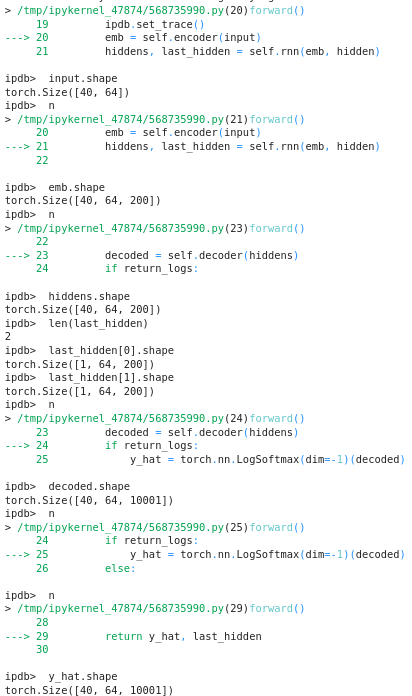


<h2>Language Generation</h2>

<div class="alert alert-warning">
    <b>Exercise 4. [30 Points]</b>
    <p>
    Copy the language generation code from the main exercise notebook and perform the following tasks:
    </p>
        <ul>
            <li>Compare all four previous models by generating $12$ words that append the starting word <tt>"despite"</tt>.</li>
            <li>For each model, retrieve the top $10$ wordIDs with the highest probabilities from the generated probability distribution (<code>prob_dist</code>) following the starting word <tt>"despite"</tt>. Fetch the corresponding words of these wordIDs. Do you observe any specific linguistic characteristic common between these words?</li>
            <li>The implementation in the main exercise notebook is based on sampling. Implement a second deterministic variant based on the <i>top-1</i> approach. In this particular variant, the generated word is the word with the highest probability in the predicted probability distribution. Repeat the same procedure as before (i.e., generate $12$ words that append the starting word <tt>"despite"</tt>).</li>
        </ul>
</div>

In [6]:
# your code goes here
for model, str_ in models:
    print('--->', str_, ':')
    GENERATION_LENGTH = 12
    START_WORD = "despite"
    
    start_hidden = None
    start_hidden_top = None
    START_WORD = START_WORD.lower()
        
    generated_text = START_WORD
    generated_text_top = START_WORD
    with torch.no_grad():
        torch.manual_seed(23) #it doesn't say to set a seed, but i'm getting different results without it
        wordid_input = dictionary.word2idx[START_WORD]
        wordid_input_top = dictionary.word2idx[START_WORD]
        for i in range(0, GENERATION_LENGTH):
            data = u6.batchify(torch.tensor([wordid_input]), 1, device)
            
            y_hat_probs, last_hidden = model(data, start_hidden, return_logs=False)
            
            prob_dist = torch.distributions.Categorical(y_hat_probs.squeeze())
            
            wordid_input = prob_dist.sample()
            word_generated = dictionary.idx2word[wordid_input]
            
            generated_text += " " + word_generated
            
            start_hidden = last_hidden
            ############

            data_top = u6.batchify(torch.tensor([wordid_input_top]), 1, device)
            
            y_hat_probs_top, last_hidden_top = model(data_top, start_hidden_top, return_logs=False)
            
            prob_dist_top = torch.distributions.Categorical(y_hat_probs_top.squeeze())
            prob_dist_top = torch.as_tensor(prob_dist_top.probs)
            
            wordid_input_top = torch.topk(prob_dist_top, 1)[1]
            word_generated_top = dictionary.idx2word[wordid_input_top]
            
            generated_text_top += " " + word_generated_top
            
            start_hidden_top = last_hidden_top
            
            #########################     
        
        data = u6.batchify(torch.tensor([wordid_input]), 1, device)
        y_hat_probs, _ = model(data, start_hidden, return_logs=False)
                
        prob_dist = torch.distributions.Categorical(y_hat_probs.squeeze())
        prob_dist = torch.as_tensor(prob_dist.probs)
        top10 = torch.topk(prob_dist, 10)[1]
        word_list = []
        for word_id in top10:
            word_list.append((int(word_id), dictionary.idx2word[word_id]))
        print('\n   - top 10 word ids with highest probabilities: \n', word_list, '\n')
    
    print('   - sampling approach:\n', generated_text, '\n\n   - top1 approach:\n', generated_text_top, '\n')

---> Model with 1 layer and without weight tying :

   - top 10 word ids with highest probabilities: 
 [(33, 'the'), (27, '<unk>'), (584, 'course'), (57, 'this'), (319, 'these'), (36, 'a'), (102, 'new'), (129, 'an'), (40, 'mr.'), (214, 'those')] 

   - sampling approach:
 despite his power had n't yet been expected to test time <eos> of 

   - top1 approach:
 despite the <unk> <eos> the <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 

---> Model with 1 layer and with weight tying :

   - top 10 word ids with highest probabilities: 
 [(33, 'the'), (27, '<unk>'), (36, 'a'), (28, 'N'), (40, 'mr.'), (109, 'in'), (79, 'it'), (316, 'but'), (110, 'its'), (226, 'he')] 

   - sampling approach:
 despite prospect litigation had n't stanza executives <eos> mich. out time more of 

   - top1 approach:
 despite the <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 

---> Model with 2 layers and without weight tying :

   - top 10 word ids with highest probabilities: 
 [(33, 'the'),

Most of the top10 words are articles (the, a, an) or pronouns/words refering to a person (his, its, their, mr., \<unk> could also be eg a name), which makes gramatical sense